# 3'READS+ Pipeline (Part 1)

**This notebook is the Part 1 of the 3'READS+ pipeline, which will do the following:**
1. Register analysis configurations for specific project/experiment
2. Read sample annotation file
3. Search, download, merge, and QC fastq files 
4. FASTQ QC and calculate length of random nucleotides in 3' ligation adapter
5. Trim 3' adapter
6. Trim 5' Ts while recording information about the trimmed sequences 
7. Map the trimmed reads to the genome 
8. Identify PASS reads and unique PASS reads using recorded information from the 5'T trimming step 
9. Cluster neighboring PASS reads in the genome to define poly(A) sites 
10. Generate summary statistics of read numbers 
11. Generate summary statistics of 5' T-stretch lengths
12. Create genome browser tracks for visualizing PASS reads 

Most of the above computation intensive steps are done by **parallel computing**.

**Required softwares**
 * [PASS.py](https://github.com/DinghaiZ/3-prime-READS-plus/blob/master/modules/PASS.py) and [zlib.R](https://github.com/DinghaiZ/3-prime-READS-plus/blob/master/modules/zlib.R) in the [modules](https://github.com/DinghaiZ/3-prime-READS-plus/tree/master/modules) folder 
 * [cutadapt](https://cutadapt.readthedocs.io/en/stable/), [STAR](https://github.com/alexdobin/STAR), [samtools](https://github.com/samtools/samtools), [genomeCoverageBed](https://bedtools.readthedocs.io/en/latest/content/tools/genomecov.html), [bedGraphToBigWig](https://bioconda.github.io/recipes/ucsc-bedgraphtobigwig/README.html), and [bedSort](https://anaconda.org/bioconda/ucsc-bedsort) in your system's PATH
 * Python packages: rpy2, time, warnings, sys, os, re, pathlib, suprocess, collections, itertools, numpy, pandas, seaborn, multiprocessing, webbrowser
 * R packages: foreach, doParallel, ShortRead, Biostrings, dplyr, tidyr, grid, ggplot2, etc
 * Jupyter Lab or Jupyter Notebook for running this notebook
 * Linux environment
 
**Hardware requirements**
 * At least 48G RAM for fast mapping of the reads using STAR. 
 * Muticore CPU for parallel computing

**For every new experiment, please create the *project_name/experiment_name/notebooks* folder and paste a copy of Part-1.ipnb and sample_description.csv there.** Then you can edit the two files to begin analysis specific for the experiment. The *data* and *results* folders will be automatically created under *project_name/experiment_name*.

## 1.1. Load packages 

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

import rpy2.robjects.numpy2ri as n2r
import os
import sys 
import re
from pathlib import Path
from subprocess import check_output
import collections
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
from time import sleep
import warnings
warnings.filterwarnings('ignore')

Import PASS.py, a python module I wrote for processing 3'READS+ data:

In [5]:
sys.path.append(str(Path('/home/dinghai/dev/3-prime-READS-plus/modules')))
import PASS as ps

## 1.2. Set configurations specific to this project and experiment
These parameters need to be specified for different projects and experiments. The format of SAMPLE_DESCRIPTION_FILE will be shown later. If you are a member of the Tian lab, you can set DATA_SOURCE to the *intron* server (intron.njms.rutgers.edu), so that the pipeline can search and down load relevant fastq files for this analysis. If you are not a member of the Tian lab, please point the DATA_SOURCE to a local folder containing fastq files.

In [6]:
GENOME = 'mm9' # Genome name, currently either mm9 or hg19

SAMPLE_DESCRIPTION_FILE = 'sample_description.csv' # Sample discription file.
    
SAVE_SPACE = True # To save disk space, delete intermediate files ASAP.    

SPIKE_IN = None # None if no spike-in, or a 4-charactor string for identifying spike-in RNA. 

# SPIKE_IN = 'ychr' # yeast RNA spike-in (if yeast chromosomes are named as 'ychr*')

DATA_SOURCE = 'intron.njms.rutgers.edu' # Either a server name or path to a local directionary. 

# DATA_SOURCE = '../tmp' # local directionary

if not Path(DATA_SOURCE).exists(): # DATA_SOURCE = 'intron.njms.rutgers.edu'
    DATA_USER = 'zhengdh'  # Use your own user name

## 1.3. Set general configurations
The following parameters are usually set once before running the notebook the first time and can be reused for different experiments. 

In [7]:
# Directory containing index files for different genomes
GENOME_INDEX_DIR = '/home/dinghai/projects/fud/star_index'

# Specific genome index for STAR
genome_index = Path(GENOME_INDEX_DIR)/GENOME
assert genome_index.exists(), f"Genome index folder {str(genome_index)} does not exist."

# Directory containing fasta files for different genomes
GENOME_FASTA_DIR = '/home/dinghai/projects/fud/ucsc/genomes' 

# Specific genome sequence in fasta format for identifying PASS reads
genome_dir = Path(GENOME_FASTA_DIR)/GENOME
assert genome_dir.exists(), f"Genome fasta file folder {str(genome_dir)} does not exist."

genome_size = Path(GENOME_FASTA_DIR)/f'{GENOME}.chrom.sizes'
assert genome_size.exists(), f"Genome size file {str(genome_size)} does not exist."

# Configurations for using UCSC genome browser to visualize PASS and nonPASS reads   
MAKE_URL = True # Set to True if you have access to an http server.        
if MAKE_URL:
    HTTP_USER = 'zhengdh' # Use your own user name
    HTTP_SERVER = 'intron.njms.rutgers.edu' # Use your own http server name

# Maximum number of processes for parallel computing
MAX_WORKERS = 8  

NUM_COLUMNS = 4  # Number of columns for fastq QC plots

# Minimum read lenth after removing 5' adapter
CUTADAPT_MINLEN = 25  

# Minimum MAPQ score for alignments in sam files
MIN_MAPQ = 10  

# Sequencing direction relative to mRNA sequence. 
SEQ_DIRECTION = 'reverse' # Either 'reverse' (antisense) or 'forward' (sense)

# Maximum distance between clustered reads in the same cluster
MAX_DISTANCE = 24 

The following lines set up directories for saving data and intermediate results.

In [8]:
# Project directory
exp_dir = Path('..')
PROJECT, EXPERIMENT = exp_dir.cwd().parts[-3:-1]

# Data directories
data_dir = exp_dir/'data'
fastq_dir = data_dir/'fastq'
sam_dir = data_dir/'sam'

# Result directory
result_dir = exp_dir/'results'

# Create directories
data_dir.mkdir(parents=True, exist_ok=True)
fastq_dir.mkdir(parents=True, exist_ok=True)
sam_dir.mkdir(parents=True, exist_ok=True)
result_dir.mkdir(parents=True, exist_ok=True)

The structure of directories should look like:

```
projects/
├── project_1
│   ├── experiment_1
│   │   ├── data
│   │   │   ├── fastq
│   │   │   └── sam
│   │   ├── notebooks
│   │   │   ├── Part-1.ipynb
│   │   │   ├── Part-2.ipynb
│   │   │   └── sample_description.csv
│   │   └── results
│   └── experiment_2
├── project_2


```

## 2. Read sample annotation and choose colors for UCSC genome browser tracks
The sample description file is a csv file containing **at least the following columns**: 

- folder_string: unique string for identifying the folder containing fastq files in the data warehouse.
- file_string: unique string for identifying the fastq files related to the corresponding sample
- sample: sample name. Recommended format: Treatment/CellType_Fraction_Batch. Example: C2C12P(CellType)_T(Total RNA)_1(Batch 1) 
- read_type: either "single" or "paired", depending on the sequencing kit. Even if a pair-end sequencing kit is used, only the first read (R1) will be used for the analysis.

If the *track_color* column is present, it must contain integers indicating which samples should have the same color for UCSC genome browser tracks. 

An example sample description file can be found in the *data_dir* defined above.


Sample description:


,folder_string,file_string,track_color,read_type
sample,,,,
NT_Ft_1,160108,AGTCAA,1,single
NT_4sU_1,160108,ATGTCA,1,single
AS_Ft_1,160108,AGTTCC,2,single
AS_4sU_1,160108,CCGTCC,2,single
NT_4sU_2,170420,ACTGAT,1,single
NT_4sU_3,170420,ATTCCT,1,single
NT_Ft_2,170420,CAACTA,1,single
NT_Ft_3,170420,CACGAT,1,single
AS_4sU_2,170420,ATGAGC,2,single


The following colors will be used for UCSC genome browser tracks:


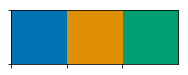

In [10]:
sample_description = pd.read_csv(SAMPLE_DESCRIPTION_FILE, dtype = 'str')

if not set(['folder_string', 'file_string', 'sample', 'read_type']) <= \
       set(sample_description.columns):
    msg = (f'The sample discription file should at least have the following columns:\n'
           f'"folder_string": unique string in the name of the folder '
           f'"file_string": string in the fastq files.\n'
           f'"sample": user defined sample name.'
           f'"read_type": either "single" or "paired"'
          )
    print(msg)
    
# Remove potential whitespace 
sample_description = sample_description.apply(lambda x: x.str.strip(), axis=1)
                      
if 'track_color' in sample_description.columns:
    sample_description = sample_description.sort_values(by=['folder_string', 'track_color'])
else:
    sample_description = sample_description.sort_values(by=['folder_string'])
    
sample_description = sample_description.set_index('sample')

print("\nSample description:")
display(sample_description)    

print('The following colors will be used for UCSC genome browser tracks:')

if 'track_color' in sample_description.columns:
    sample_description.track_color = sample_description.track_color.astype(int)
    color_max = sample_description.track_color.max(axis=0)
else:
    color_max = sample_description.shape[0]
    
sns.palplot(sns.color_palette("colorblind", color_max))

## 3. Find, download, merge, and rename fastq files
Often I need to pull data from different sequencing runs stored on an internal data warehouse and analyze them together. The datasets in the warehouse may be moved around by the administrator. Therefore, I use the *folder_string* to search the data warehouse for folders that may contain the data. Then it will download fastq files matching *file_string* in those folders. Downloaded fastq files with the same *file_string* will be merged and renamed using the corresponding *sample* name defined in SAMPLE_DESCRIPTION_FILE.

If the fastq files are already in a local folder, simply copy, merge, and rename fastq files.

In [11]:
for folder_string in sample_description.folder_string.unique():
    fastq_subdir = fastq_dir/folder_string
    fastq_subdir.mkdir(parents=True, exist_ok=True)
    df = sample_description[sample_description.folder_string == folder_string]
    
    # DATA_SOURCE is something like 'intron.njms.rutgers.edu'
    if not re.search(r'\/', DATA_SOURCE):
        
        # Find folders in the warehouse that may contain the fastq files
        cmd = f'ssh {DATA_USER}@{DATA_SOURCE} find ../database* -type d -name {folder_string}*'
        print(f'\nSearching folders with {folder_string} in their names on {DATA_SOURCE}')
        print(f'\nUsing command "{cmd}"')
        fastq_folders = check_output(cmd, shell=True).decode().split('\n')
        print('\nFastq folders found:')
        print('\n'.join(fastq_folders))

        # Find and download fastq files in the folders
        for file_string in df.file_string:
            sample_name = df[df.file_string == file_string].index[0]
            # Some of the folders may not contain fastq data
            for fastq_folder in fastq_folders:
                cmd = (f'ssh {DATA_USER}@{DATA_SOURCE} find {fastq_folder}'
                       f' -type f -name "*{file_string}*R1*"')
                # print(cmd)
                fastq_files = check_output(cmd, shell=True).decode().replace('\n', " ")
                # Escape special characters
                fastq_files = fastq_files.replace("&", "\&").replace(":", "\:")
                # Skip the current fastq_folder if fastq_files have already been found
                if not fastq_files == '': 
                    break
                    
            # Download fastq files from internal server
            print('\nDownloading fastq files ....')
            cmd = f'scp -r {DATA_USER}@{DATA_SOURCE}:"{fastq_files}" {fastq_subdir}'
            print(cmd)
            os.system(cmd)
            
    # If fastq files are in a local folder:    
    elif Path(DATA_SOURCE).exists():
        cmd = f'find {DATA_SOURCE} -type d -name "{folder_string}*"'
        fastq_subdir = check_output(cmd, shell=True).decode().strip() 
        print('\nLocal fastq folders found:', fastq_subdir)

    # Merge fastq files in the folder
    for file_string in df.file_string:
        sample_name = df[df.file_string == file_string].index[0]

        # Get file names
        R1_fastq_gz = [str(filename) for filename in Path(fastq_subdir).iterdir() 
                       if re.search(file_string + '.*fastq.gz$', str(filename))]
        
        R1_fastq = [str(filename) for filename in Path(fastq_subdir).iterdir() 
                    if re.search(file_string + '.*fastq$', str(filename))]

        # In case that both .fastq and .fastq.gz files exist for the same sample
        R1_fastq_gz = [filename for filename in R1_fastq_gz if not 
                       filename.replace('.gz', '') in R1_fastq]

        # Merge files
        ps.merge_and_rename(R1_fastq_gz, f'{sample_name}.fastq', fastq_dir)
        ps.merge_and_rename(R1_fastq, f'{sample_name}.fastq', fastq_dir)
    
     
    print('\nDone!')


Searching folders with 160108 in their names on intron.njms.rutgers.edu

Using command "ssh zhengdh@intron.njms.rutgers.edu find ../database* -type d -name 160108*"

Fastq folders found:
../database8/Data01/FASTQ/160108_NB500952_0037_AHL7HLBGXX


scp -r zhengdh@intron.njms.rutgers.edu:"../database8/Data01/FASTQ/160108_NB500952_0037_AHL7HLBGXX/Decay/AGTCAA_S13_L001_R1_001.fastq.gz ../database8/Data01/FASTQ/160108_NB500952_0037_AHL7HLBGXX/Decay/AGTCAA_S13_L002_R1_001.fastq.gz ../database8/Data01/FASTQ/160108_NB500952_0037_AHL7HLBGXX/Decay/AGTCAA_S13_L003_R1_001.fastq.gz ../database8/Data01/FASTQ/160108_NB500952_0037_AHL7HLBGXX/Decay/AGTCAA_S13_L004_R1_001.fastq.gz " ../data/fastq/160108

scp -r zhengdh@intron.njms.rutgers.edu:"../database8/Data01/FASTQ/160108_NB500952_0037_AHL7HLBGXX/Decay/ATGTCA_S15_L003_R1_001.fastq.gz ../database8/Data01/FASTQ/160108_NB500952_0037_AHL7HLBGXX/Decay/ATGTCA_S15_L004_R1_001.fastq.gz ../database8/Data01/FASTQ/160108_NB500952_0037_AHL7HLBGXX/Decay/ATGTCA_S

The following code determines number of workers for parallel computing. 

In [12]:
fastq_files = sorted([str(filename.absolute()) for filename in fastq_dir.glob('*.fastq')])

if len(fastq_files) == 0:
    print(f"\nPleae put fastq files in the {str(fastq_dir)} folder first.")    
    
WORKERS = min(MAX_WORKERS, len(fastq_files))

print(f'\n{WORKERS} workers will be used for all (except mapping) parallel computing.')    


8 workers will be used for all (except mapping) parallel computing.


Count raw fastq records in fastq files in parallel:

In [13]:
# Count raw reads   
with mp.Pool(processes=WORKERS) as pool:
    raw_fastq_counts = pool.map(ps.count_fastq, fastq_files)
    
raw_fastq_counts = pd.DataFrame(raw_fastq_counts, columns = ["File_Name", "Raw"])
raw_fastq_counts["File_Name"] = raw_fastq_counts["File_Name"].str.replace('.fastq', '') 
raw_fastq_counts = raw_fastq_counts.set_index("File_Name")

print('\nRaw fastq count in each file:')
raw_fastq_counts 


Raw fastq count in each file:


,Raw
File_Name,
AS_4sU_1,14158254
AS_4sU_2,34322197
AS_Ft_1,10222831
AS_Ft_2,28587835
NT_4sU_1,16283546
NT_4sU_2,37619965
NT_4sU_3,53111239
NT_Ft_1,12827342
NT_Ft_2,30025438


## 4. FASTQ QC and calculate length of random nucleotides in 3' ligation adapter
The following R code plots fastq quality using code adopted from the [seeFastq()](https://rdrr.io/github/Bioconductor-mirror/systemPipeR/man/seeFastq.html) function. **In the Proportion vs Cycle plots, you can see stretches of Ts near the 5' end of the reads if the library quality is high.**  

For libraries prepared using different versions of 3' adapters (usually in different batches), the numbers of random nucleotides could be different. **The following code will also figure out the number of random nucleotides (*random_NT_lens*) in the 3' adapter (5' end of the reads when the libraries are sequenced in reverse direction).** The *random_NT_lens* for each sample will be used for identifying PASS reads and unique PASS reads later. 

In [18]:
result_dir_str = str(result_dir.absolute()) # For R input


Number of random nucleotides in 5' end of the fastq reads:

AS_4sU_1 AS_4sU_2  AS_Ft_1  AS_Ft_2 NT_4sU_1 NT_4sU_2 NT_4sU_3  NT_Ft_1 
       3        6        3        6        3        6        6        3 
 NT_Ft_2  NT_Ft_3 RC_4sU_2  RC_Ft_2 
       6        6        6        6 



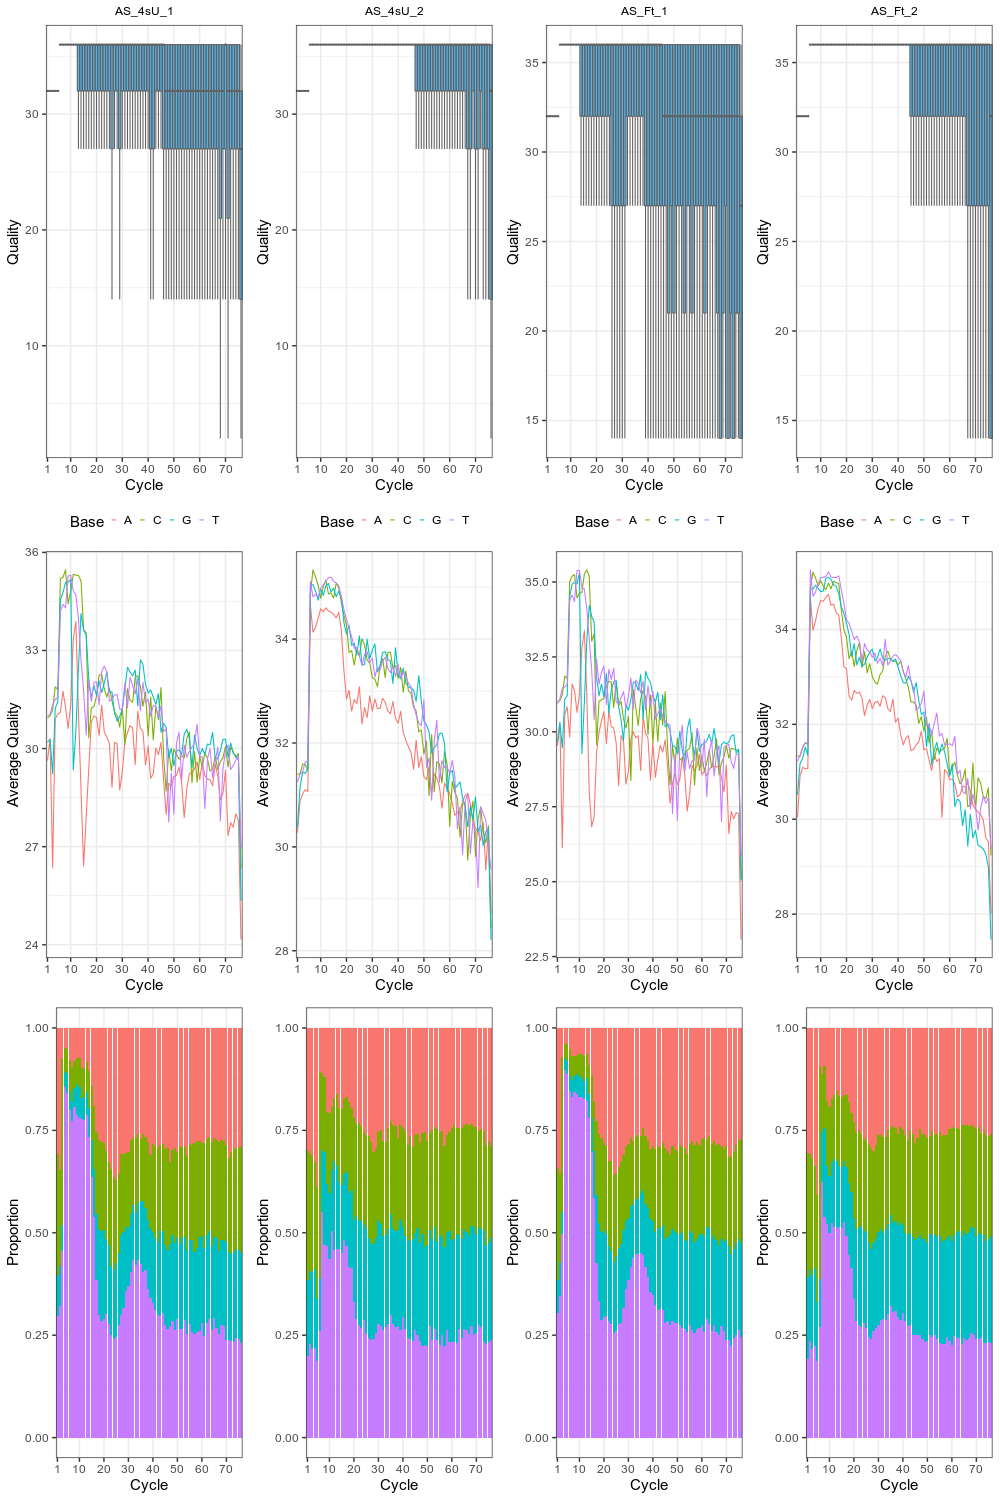

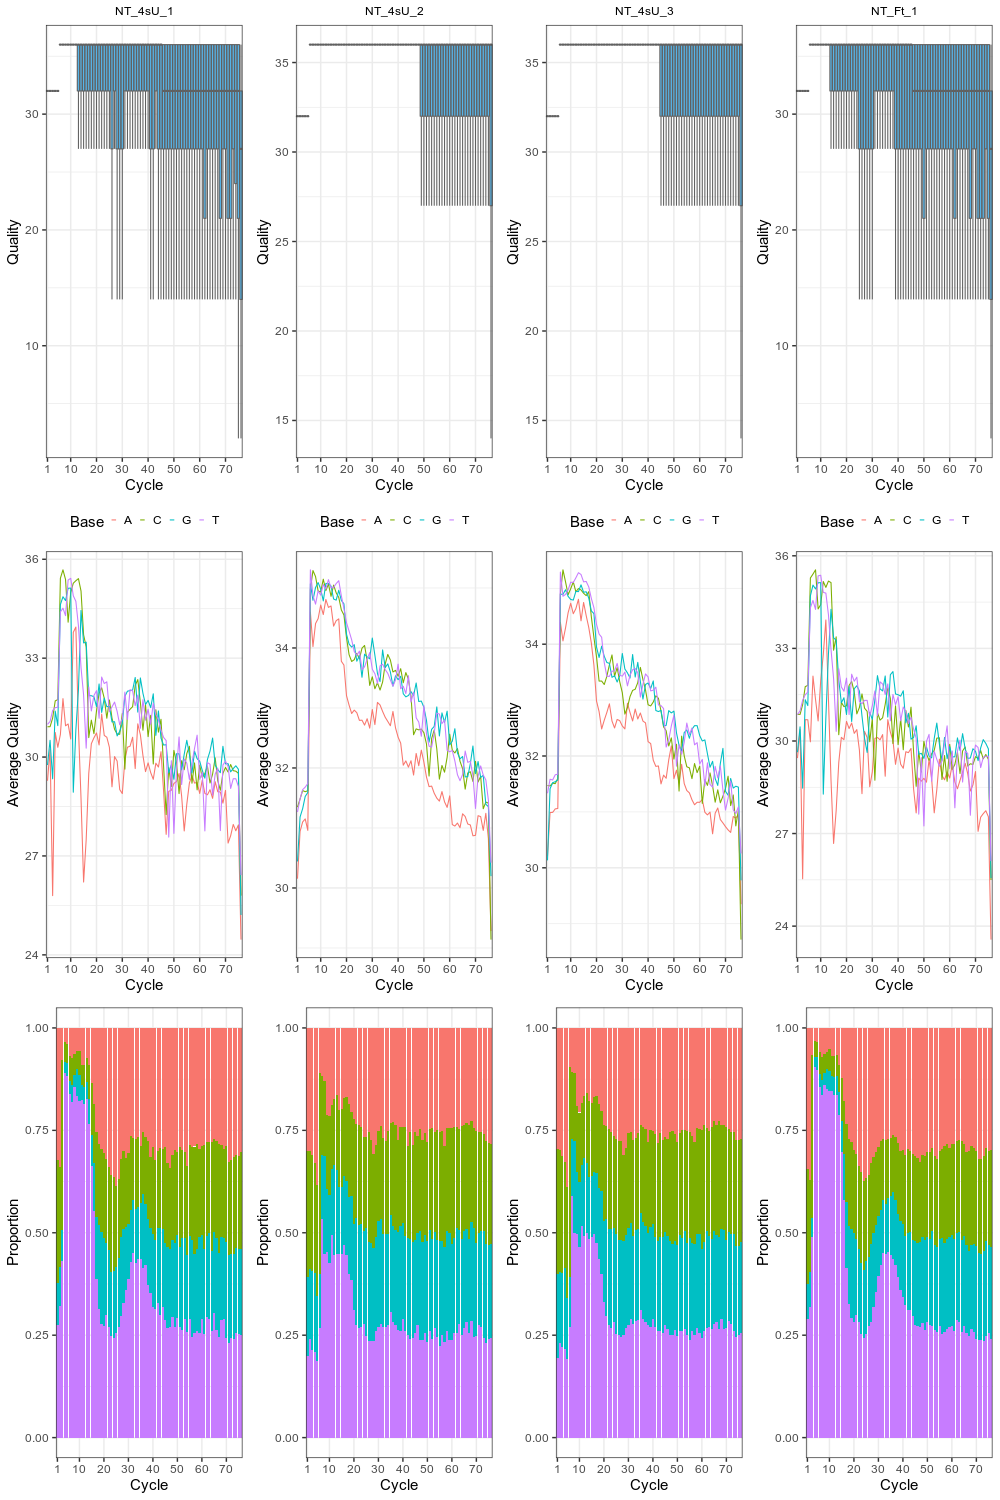

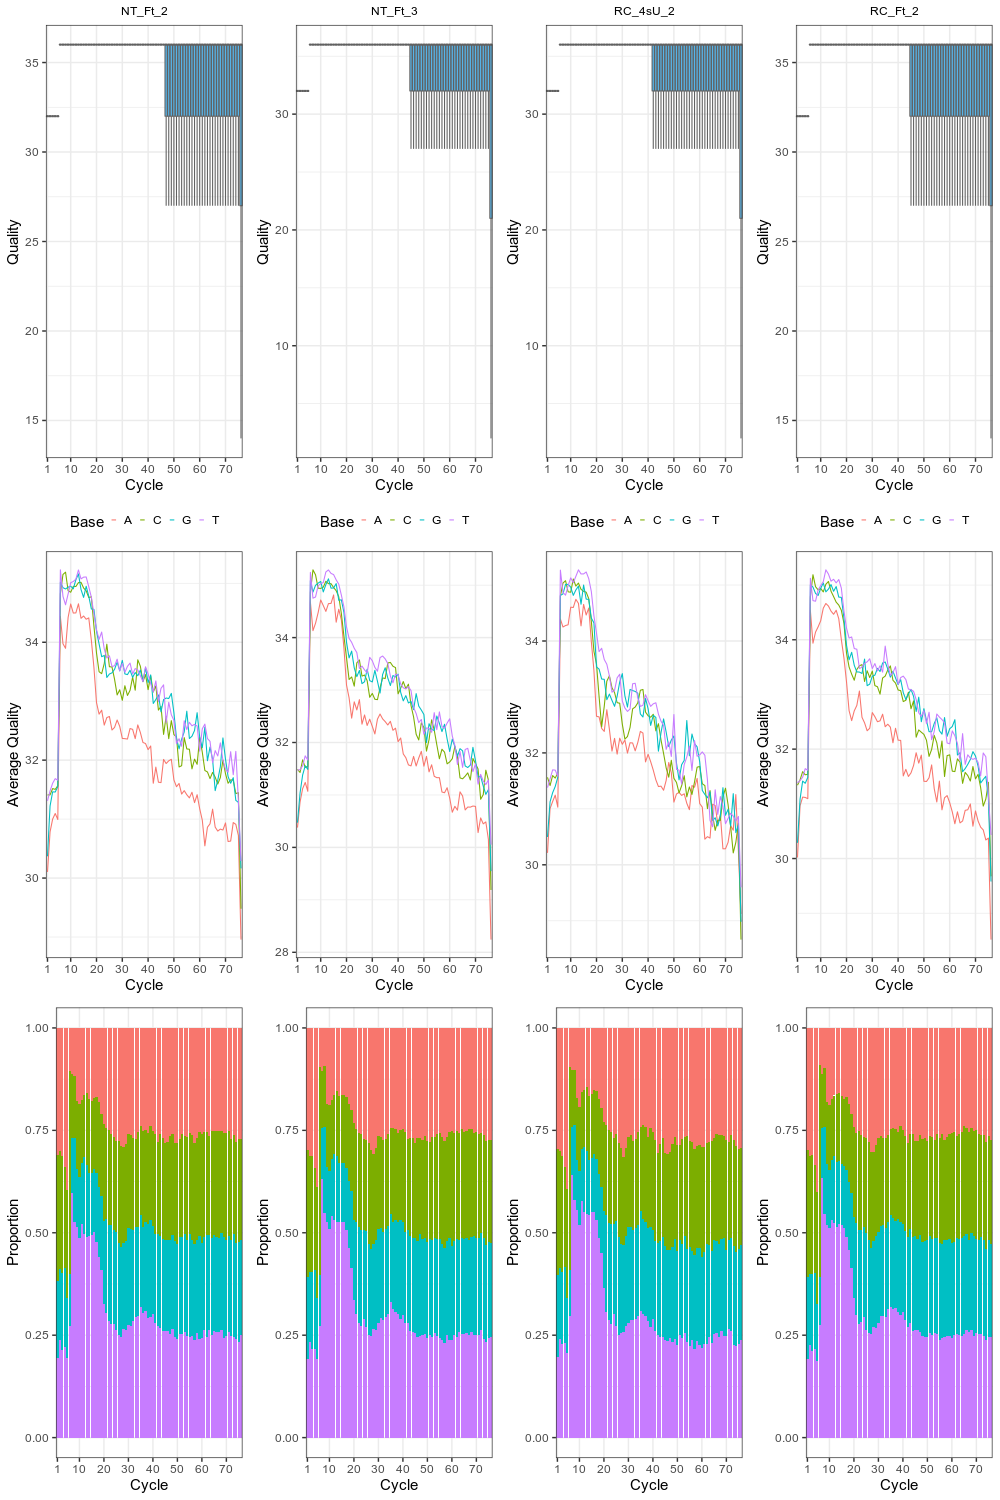

In [19]:
%%R -i fastq_files,NUM_COLUMNS,result_dir_str,WORKERS -w 1000 -h 1500 -o random_NT_lens

## Load helper functions
source("/home/dinghai/dev/3-prime-READS-plus/modules/dzlib.R")
library(foreach)
library(doParallel)

## Step 1: Creat list of plots using parellel computing             
registerDoParallel(WORKERS)   
fqlist = foreach(f = 1:length(fastq_files), 
                 .packages = c("ShortRead", "Biostrings")) %dopar% {
    seeFastq(fastq = fastq_files[[f]])
    }
names(fqlist) = sapply(fastq_files, function(x) sub(".+\\/(.+).fastq", "\\1", x))                     

## Step 2: Output pdf and browser image              
mycol = seq(along = fqlist)     
myrow = c(1, 3, 2)
n = min(NUM_COLUMNS, length(fastq_files))                                                
if(length(mycol) %% n){
  groups = 0:floor(length(mycol)/n)
}else{
  groups = 0:(length(mycol)/n - 1)
}  
                       
# Make pdf plots                        
pdf(file.path(result_dir_str, "fastqReport.pdf"), height=20, width=4*n)                         
for(group in groups){
  if(group < max(groups)){
    subcol = mycol[n*group + 1:n]
  }else{
    subcol = mycol[(n*group + 1):length(mycol)]
  }
  seeFastqPlot(fqlist[subcol], arrange = myrow, n = n)
}
dev.off()  
                       
# Print to screen
for(group in groups){
  if(group < max(groups)){
    subcol = mycol[n*group + 1:n]
  }else{
    subcol = mycol[(n*group + 1):length(mycol)]
  }
  seeFastqPlot(fqlist[subcol], arrange = myrow, n = n)
}       
                
# Automatically figure out the number of random nucleotides in the 3' adapter 
# (5' end of the reads when the libraries are sequenced in reverse direction) 
cycle_with_max_T_frequency = function(fq){
    base_frequency = fq$bstats
    T_frequency = subset(base_frequency, Base == "T")
    # The number of random nucleotides in the 3'adapter is also where 
    # the frequency of T increased most 
    which.max(diff(T_frequency$Frequency))
}
                       
random_NT_lens = sapply(fqlist, cycle_with_max_T_frequency)
names(random_NT_lens) = names(fqlist)

cat("\nNumber of random nucleotides in 5' end of the fastq reads:\n\n")
print(random_NT_lens)
cat("\n")                       

## 5. Clip adapters 
This step removes the read's 3' end adapter (originated from 5' RNA ligation adapter) from the reads using [cutadapt](https://cutadapt.readthedocs.io/en/stable/). Again, parallel computing is used for speed. If paired-end sequencing was used (usually 150 nt x 2), only keep the first 75 bases from Read 1.  

In [20]:
cmds = [] 
for sample_name in sample_description.index:
    fastq_file = str(fastq_dir/f'{sample_name}.fastq')
    read_type = sample_description.loc[sample_name, 'read_type']
    if read_type == 'single':
        cmd = (f'cutadapt -a NNNNTGGAATTCTCGGGTGCCAAGG -n 1 -O 10 -m {CUTADAPT_MINLEN} '
               f'-f fastq -q 10 {fastq_file} '
               f'-o {fastq_file.replace(".fastq", ".cut.fastq")} '
               f'&& rm {fastq_file}')
    elif read_type == 'paired':
        cmd = (f'cutadapt -u -75 -a NNNNTGGAATTCTCGGGTGCCAAGG -n 1 -O 10 -m {CUTADAPT_MINLEN} '
               f'-f fastq -q 10 {fastq_file} -o {fastq_file.replace(".fastq", ".cut.fastq")} '
               f'&& rm {fastq_file}')
    cmds.append(cmd)

In [21]:
print("\nRemoving ligation adapters from fastq reads in the following files:\n") 
print('\n'.join([fastq_file.split('/')[-1] for fastq_file in fastq_files]))

with mp.Pool(processes = WORKERS) as pool: 
    pool.map(os.system, cmds)
    
print('\nDone!')


Removing ligation adapters from fastq reads in the following files:

AS_4sU_1.fastq
AS_4sU_2.fastq
AS_Ft_1.fastq
AS_Ft_2.fastq
NT_4sU_1.fastq
NT_4sU_2.fastq
NT_4sU_3.fastq
NT_Ft_1.fastq
NT_Ft_2.fastq
NT_Ft_3.fastq
RC_4sU_2.fastq
RC_Ft_2.fastq

Done!


## 6. Trim 5' Ts 
As explained in the README, it is important to trim 5' Ts before mapping the reads to the genome. This is done by the trim_write_count_fastq() function in the PASS moduel. It saves the random nucleotides before 5' T-stretches and the size of T-stretches in the read name, so that the information can be used later for identifying PASS and unique PASS reads. 

Some reads have mutations in the middle of the T stretch (such as TATCTCTTTTATTTTTTTTTTTTGAAGGGCAGATTTAAAATACACTATTAAAATTATTAA) due to the difficulty in sequencing homopolymers. These reads will be trimmed twice and the sequences trimmed during the second trimming will be compared with genomic sequences to determine if the second trmming is legitimate.  

In [22]:
cutadapt_outputs = sorted([str(filename.absolute()) 
                           for filename in fastq_dir.glob('*cut.fastq')])

print("\nTrimming 5' T-stretches from fastq reads in the following files:\n") 
print('\n'.join([fastq_file.split('/')[-1] for fastq_file in cutadapt_outputs]))

with mp.Pool(processes = WORKERS) as pool:
    trimmed_fastq_counts = pool.starmap(ps.trim_write_count_fastq, 
                                        list(zip(cutadapt_outputs, 
                                                 list(random_NT_lens), 
                                                 [4]*len(random_NT_lens)
                                                )
                                            )
                                       )
    
if SAVE_SPACE:
    cmd = 'rm ' + ' '.join(cutadapt_outputs)
    os.system(cmd)    

print('\nDone!')

trimmed_fastq_counts = pd.DataFrame(trimmed_fastq_counts, 
                                    columns = ["File_Name", "Cut", "Trimmed"])
trimmed_fastq_counts["File_Name"] = trimmed_fastq_counts["File_Name"]\
                                    .str.replace('.cut.fastq', '')  
trimmed_fastq_counts = trimmed_fastq_counts.set_index("File_Name")
fastq_counts = pd.concat([raw_fastq_counts, trimmed_fastq_counts], axis = 1)

print('\nFastq counts in each file:')
fastq_counts


Trimming 5' T-stretches from fastq reads in the following files:

AS_4sU_1.cut.fastq
AS_4sU_2.cut.fastq
AS_Ft_1.cut.fastq
AS_Ft_2.cut.fastq
NT_4sU_1.cut.fastq
NT_4sU_2.cut.fastq
NT_4sU_3.cut.fastq
NT_Ft_1.cut.fastq
NT_Ft_2.cut.fastq
NT_Ft_3.cut.fastq
RC_4sU_2.cut.fastq
RC_Ft_2.cut.fastq

Done!

Fastq counts in each file:


,Raw,Cut,Trimmed
File_Name,,,
AS_4sU_1,14158254,13633049,11849567
AS_4sU_2,34322197,29070324,16068575
AS_Ft_1,10222831,10047840,9059749
AS_Ft_2,28587835,25732858,16217257
NT_4sU_1,16283546,15511664,14197038
NT_4sU_2,37619965,32322461,17342269
NT_4sU_3,53111239,44242849,26337356
NT_Ft_1,12827342,12629909,11524890
NT_Ft_2,30025438,27709417,16931931


## 7. Map the reads to the genome using STAR 

According to the STAR manual, add the following lines to /etc/sysctl.conf:

kernel.shmmax = 31000000000 

kernel.shmall = 7568360

Then run 'sudo /sbin/sysctl -p' to allow large shared memory blocks.

_AlignEndsType_ is set to _EndToEnd_ for higher mapping accuracy.

In [23]:
trimmed_fastq_files = sorted([str(filename.absolute()) 
                              for filename in fastq_dir.glob('*trimmed.fastq')])
# Commands for mapping reads
cmds = [(f'STAR --runThreadN {os.cpu_count()} '
         f'--genomeDir {genome_index} --genomeLoad LoadAndKeep '
         f'--readFilesIn {fastq_file} --alignEndsType EndToEnd --outFilterType BySJout '
         f'--outFilterMultimapNmax 10 --alignSJoverhangMin 8 --alignSJDBoverhangMin 1 '
         f'--outSAMmultNmax 1 '
         f'--alignIntronMin 20 --alignIntronMax 1000000 --outFileNamePrefix '
         f'{fastq_file.replace("/fastq/", "/sam/").replace("cut.trimmed.fastq", "")}') 
         for fastq_file in trimmed_fastq_files]

# Commands for removing fastq files
cmds_rm = ['rm ' + fastq_file for fastq_file in trimmed_fastq_files]  

Have a look at the command:

In [24]:
cmds[0]

'STAR --runThreadN 8 --genomeDir /home/dinghai/projects/fud/star_index/mm9 --genomeLoad LoadAndKeep --readFilesIn /home/dinghai/projects/stability/NT_AS_RC/notebooks/../data/fastq/AS_4sU_1.cut.trimmed.fastq --alignEndsType EndToEnd --outFilterType BySJout --outFilterMultimapNmax 10 --alignSJoverhangMin 8 --alignSJDBoverhangMin 1 --outSAMmultNmax 1 --alignIntronMin 20 --alignIntronMax 1000000 --outFileNamePrefix /home/dinghai/projects/stability/NT_AS_RC/notebooks/../data/sam/AS_4sU_1.'

In [25]:
print(f'\nMapping reads from the following files to {GENOME}:\n') 
print('\n'.join([fastq_file.split('/')[-1] for fastq_file in trimmed_fastq_files]))

# Map reads and then delete fastq files immediately
for i in range(len(cmds)):
    os.system(cmds[i])    
    if SAVE_SPACE:
        os.system(cmds_rm[i])
    
# Remove genome from memory. Note "--genomeDir" is still needed!
cmd = f'STAR --genomeDir {genome_index} --genomeLoad Remove'
os.system(cmd)

print('\nDone!')


Mapping reads from the following files to mm9:

AS_4sU_1.cut.trimmed.fastq
AS_4sU_2.cut.trimmed.fastq
AS_Ft_1.cut.trimmed.fastq
AS_Ft_2.cut.trimmed.fastq
NT_4sU_1.cut.trimmed.fastq
NT_4sU_2.cut.trimmed.fastq
NT_4sU_3.cut.trimmed.fastq
NT_Ft_1.cut.trimmed.fastq
NT_Ft_2.cut.trimmed.fastq
NT_Ft_3.cut.trimmed.fastq
RC_4sU_2.cut.trimmed.fastq
RC_Ft_2.cut.trimmed.fastq

Done!


## 8.1. Identfy PASS reads

This step will split the reads in sam files into PASS, nonPASS, and spike-in reads. PASS reads are defined as reads containing at least 2 extra Ts originated from the poly(A) tail but not from the genome. Each PASS read comes from a cleavage and polyadenylation site (CPS) in the genome.  

Note: if the split_sam() function is not defined in the notebook but loaded from PASS.py, genome will not be available for all processes, so I have to define the split_sam() function in the notebook.

In [26]:
def split_sam(sam_file, min_mapq = 10, direction = 'reverse', spike_in = None):
    '''Split a sam_file into PASS, nonpass, and spike-in sam files.

    Loop through records in the sam file, if the record is PASS, write to
    pass_file. Mapped non-PASS reads are saved in nonpass_file. Reads mapped to 
    rRNA genes are skipped. Sequencing direction can only be reverse or forward. 

    Attach matched tail length (ML), unmatched tail length (UL), and last mapped
    position (LM) to the end of readname. The head (such as 'TS11AAC') and the 
    tail (such as 'ML:i:4\tUL:i:9\tLM:i:1234') of the read name is the unique 
    identifier of the read.
    
    Arguments:
    sam_file: string. Name of input sam file.
    min_mapq: int. Minimum MAPQ score
    direction: string. Either 'reverse' (default) or 'forward'
    spike_in: a 4-charactor string for identifying spike-in RNA. For example,
    spike_in = 'ychr' for spike-in yeast RNA if yeast chromosomes are named as 'ychr1', 
    'ychrM', etc. 
    
    Outputs:
    Separate sam files containing either PASS reads, nonPASS reads, or spike-ins.
    '''
    pass_file = open(sam_file.replace('.sam', '.pass'), 'w')
    nonpass_file = open(sam_file.replace('.sam', '.nonpass'), 'w')
    if spike_in: spike_in_file = open(sam_file.replace('.sam', '.spike_in'), 'w')
    
    lap = 0

    with open(sam_file, 'r') as fin:
        for line in fin:
            # Skip header
            if line[0] == '@':
                pass_file.write(line)
                nonpass_file.write(line)
                if spike_in: spike_in_file.write(line)
                continue
            # Process each line
            (readname, flag, chromosome, position, mapq, cigar) = line.split()[:6]
            position = int(position)
            mapq = int(mapq)

            # Discard reads with low mapping scores
            if mapq < min_mapq:
                continue
            # Record reads mapped to spiked-in yeast genome 
            if spike_in and chromosome[:4] == spike_in:  
                spike_in_file.write(line)
                continue
            # Ignore reads mapped to other chromosomes, such as 'BK000964'
            if not chromosome[:3] == 'chr':
                continue

            # Extract the T-stretch length encoded in the readname
            match = re.match('TS(\d+)', line)
            t_stretch_len = int(match.groups()[0])

            # Get genomic sequence downstream of the LAP (last mapped position).
            # (The length of returned sequence is t_stretch_len.)
            if (direction.lower() == 'reverse' and flag == '16') or \
               (direction.lower() == 'forward' and flag == '0'):
                strand = '+'
                # Process cigar to determine the LAP.
                # Insertion (I) will not affect the covered distance.
                nums = re.split('[MDN]', re.sub('\d+I', '', cigar))[:-1]
                covered = sum(int(x) for x in nums)
                # get_seq() returns reverse complemented sequence if strand == '-'
                downstream_seq = ps.get_seq(chromosome, 
                                            strand,
                                            start = position + covered,
                                            end = position + covered + t_stretch_len - 1,
                                            genome = genome)
                lap = position + covered - 1
            elif (direction.lower() == 'reverse' and flag == '0') or \
                 (direction.lower() == 'forward' and flag == '16'):
                strand = '-'
                downstream_seq = ps.get_seq(chromosome, 
                                            strand,
                                            start = position - t_stretch_len, 
                                            end = position - 1,
                                            genome = genome)
                lap = position
            else:
                continue

            # If the 5' T-stretch was trimmed twice (like 'TTTTTTTGTTTT')
            # and if GTTTT (reverse-compliment: AAAAC) comes from the genome,
            # update the downstream_seq, lap, and t_stretch_len
            elements = readname.split('::')
            if len(elements) == 2:
                elements[1] = elements[1].split(':')[0]   
                match = re.match(ps.reverse_complement(elements[1]), downstream_seq)
                if match:
                    downstream_seq = downstream_seq[len(elements[1]):]
                    t_stretch_len -= len(elements[1])
                    if strand == '+':
                        lap += len(elements[1])
                    if strand == '-':
                        lap -= len(elements[1])
            
            # If the t_stretch_len is reduced enough, no need to analyze downstream sequence
            #assert t_stretch_len >= 0
            
            if t_stretch_len == 0:
                nonpass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
                                      % (0, 0, lap))
                continue

            # Check if downstream sequence matches trimmed T-stretches 
            if not downstream_seq[:-1] == 'A' * (t_stretch_len - 1):
                match = re.match('A+', downstream_seq)
                matched_len = len(match.group()) if match else 0
                # ML: Matched Length 
                # UL: Unmatched Length
                # LM: Last Mapped position(UL) 
                pass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
                                    % (matched_len, t_stretch_len - matched_len, lap))
            # If t_stretch_len == 1, the following block will also run.
            else:
                match = re.match('A*', downstream_seq)
                matched_len = len(match.group())  
                nonpass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
                                      % (matched_len, t_stretch_len - matched_len, lap))
    pass_file.close()
    nonpass_file.close()
    if spike_in: spike_in_file.close()
    
    os.system('rm ' + sam_file)

In [27]:
# List of sam files as input
sam_files = sorted(str(sam_file) for sam_file in sam_dir.glob('*Aligned.out.sam'))
l = len(sam_files)

print('\nPicking PASS reads from the following files:\n') 
print('\n'.join([sam_file.split('/')[-1] for sam_file in sam_files]))

# Genome loaded into memory is available for all processes
genome = ps.load_fasta_genome(genome_dir)

# Try parallel computing, which requires more disk space
try:
    with mp.Pool(processes = WORKERS) as pool:
        pool.starmap(split_sam, 
                     zip(sam_files, [MIN_MAPQ]*l, [SEQ_DIRECTION]*l, [SPIKE_IN]*l))
except OSError:
    os.system(f'rm {str(sam_dir)}/*pass')
    if SPIKE_IN: os.system(f'rm {str(sam_dir)}/*.spike_in')
    print("\nNo space left on device. Trying again with parallel computing turned off.")
    for sam_file in sam_files:
        print("Processing ", sam_file)
        split_sam(sam_file = sam_file)

# Release memory    
del genome  

print('\nDone!') 


Picking PASS reads from the following files:

AS_4sU_1.Aligned.out.sam
AS_4sU_2.Aligned.out.sam
AS_Ft_1.Aligned.out.sam
AS_Ft_2.Aligned.out.sam
NT_4sU_1.Aligned.out.sam
NT_4sU_2.Aligned.out.sam
NT_4sU_3.Aligned.out.sam
NT_Ft_1.Aligned.out.sam
NT_Ft_2.Aligned.out.sam
NT_Ft_3.Aligned.out.sam
RC_4sU_2.Aligned.out.sam
RC_Ft_2.Aligned.out.sam

Done!


## 8.2. Pick unique PASS reads
This step uses the random nucleotides (previously saved in read name), T-stretch size (previously saved in read name), chromosome, strand, and last mapped position to remove potential PCR duplicates

In [28]:
pass_files = sorted(str(pass_file) for pass_file in sam_dir.glob('*Aligned.out.pass'))
print('\nPicking unique PASS reads from the following files:\n') 
print('\n'.join([pass_file.split('/')[-1] for pass_file in pass_files]))

with mp.Pool(processes = WORKERS) as pool:
    pool.starmap(ps.pick_unique_pass, list(zip(pass_files, list(random_NT_lens))))
    
print('\nDone!')     


Picking unique PASS reads from the following files:

AS_4sU_1.Aligned.out.pass
AS_4sU_2.Aligned.out.pass
AS_Ft_1.Aligned.out.pass
AS_Ft_2.Aligned.out.pass
NT_4sU_1.Aligned.out.pass
NT_4sU_2.Aligned.out.pass
NT_4sU_3.Aligned.out.pass
NT_Ft_1.Aligned.out.pass
NT_Ft_2.Aligned.out.pass
NT_Ft_3.Aligned.out.pass
RC_4sU_2.Aligned.out.pass
RC_Ft_2.Aligned.out.pass

Done!


## 9. Cluster all PASS or unique PASS reads
PASS reads with the last mapped positions within a MAX_DISTANCE (24)-nt window are clustered to define a pA site (PAS). For PASS reads distributed in a larger window but still within 24-nt from at least one neighboring PASS read, the clustering is done in a divide-and-conquer manner. By the way, I am really grateful for the algorithm [courses](https://www.coursera.org/specializations/algorithms) on Coursera.   

In [29]:
# Cluster all PASS reads
pass_files = sorted(str(pass_file) for pass_file in sam_dir.glob('*Aligned.out.pass'))
pass_reads_output = result_dir/'clusters.using.all.reads.csv'

ps.cluster_pass_reads(pass_files, 
                      output = pass_reads_output,
                      direction = SEQ_DIRECTION, 
                      max_distance = MAX_DISTANCE)

Reading sam files containing PASS reads ...
Clustering reads ...
Writing to output file ...
Done!


**Take a look at the head of the cluster file:**

In [30]:
pd.read_csv(pass_reads_output).head()

,chromosome,strand,position,AS_4sU_1,AS_4sU_2,AS_Ft_1,AS_Ft_2,NT_4sU_1,NT_4sU_2,NT_4sU_3,NT_Ft_1,NT_Ft_2,NT_Ft_3,RC_4sU_2,RC_Ft_2
0,chrX,+,3018220,0,0,0,0,0,0,0,0,0,0,1,0
1,chrX,+,3018841,0,0,0,0,0,1,0,0,0,0,1,0
2,chrX,+,3037454,0,0,0,0,0,0,0,0,0,0,1,0
3,chrX,+,3046899,0,0,0,0,0,0,0,0,0,0,1,0
4,chrX,+,3101649,0,0,0,0,0,0,0,0,0,1,0,0


In [31]:
# Cluster unique PASS reads
upass_files = sorted(str(pass_file) for pass_file in sam_dir.glob('*Aligned.out.unique.pass'))
upass_reads_output = result_dir/'clusters.using.unique.reads.csv'

ps.cluster_pass_reads(upass_files, 
                      output = upass_reads_output,
                      direction = SEQ_DIRECTION, 
                      max_distance = MAX_DISTANCE)


Reading sam files containing PASS reads ...
Clustering reads ...
Writing to output file ...
Done!


**Take a look at the end of the cluster file:**

In [32]:
pd.read_csv(upass_reads_output).tail()

,chromosome,strand,position,AS_4sU_1,AS_4sU_2,AS_Ft_1,AS_Ft_2,NT_4sU_1,NT_4sU_2,NT_4sU_3,NT_Ft_1,NT_Ft_2,NT_Ft_3,RC_4sU_2,RC_Ft_2
1569280,chr13_random,-,396574,0,0,0,0,0,0,1,0,1,1,2,0
1569281,chr13_random,-,396768,0,0,0,0,0,1,0,0,0,0,1,0
1569282,chr17_random,-,283255,0,0,0,0,0,1,0,0,0,0,0,0
1569283,chr17_random,-,383054,0,0,0,0,0,0,1,0,0,0,0,0
1569284,chr17_random,+,440389,0,1,0,0,0,0,0,0,0,0,0,0


## 10. Read number statistics
This is another QC for 3'READS+. For high quality 3'READS+ libraries, the % of PASS reads should be 60~90%.

In [33]:
with mp.Pool(processes = WORKERS) as pool: 
    pass_counts = pool.map(ps.count_sam, pass_files)
    
pass_counts = pd.DataFrame(pass_counts, columns = ['Sample', 'PASS'])
pass_counts.iloc[:,0] = pass_counts.iloc[:,0].str.replace('.Aligned.out.pass', '')
pass_counts = pass_counts.set_index('Sample')   



nonpass_files = sorted(str(nonpass_file) 
                       for nonpass_file in sam_dir.glob('*Aligned.out.nonpass'))
with mp.Pool(processes = WORKERS) as pool: 
    nonpass_counts = pool.map(ps.count_sam, nonpass_files)
    
nonpass_counts = pd.DataFrame(nonpass_counts, columns = ['Sample', 'nonPASS'])
nonpass_counts.iloc[:,0] = nonpass_counts.iloc[:,0].str.replace('.Aligned.out.nonpass', '')
nonpass_counts = nonpass_counts.set_index('Sample')  


    
with mp.Pool(processes = WORKERS) as pool: 
    upass_counts = pool.map(ps.count_sam, upass_files)
    
upass_counts = pd.DataFrame(upass_counts, columns = ['Sample', 'uPASS'])
upass_counts.iloc[:,0] = upass_counts.iloc[:,0].str.replace('.Aligned.out.unique.pass', '')
upass_counts = upass_counts.set_index('Sample')    



if SPIKE_IN: 
    spike_in_files = sorted(str(nonpass_file) 
                            for nonpass_file in sam_dir.glob('*Aligned.out.spike_in'))
    with mp.Pool(processes = WORKERS) as pool: 
        spike_in_counts = pool.map(ps.count_sam, spike_in_files)
    spike_in_counts = pd.DataFrame(spike_in_counts, columns = ['Sample', 'Spike-in'])
    spike_in_counts.iloc[:,0] = spike_in_counts.iloc[:,0]\
                                .str.replace('.Aligned.out.Spike-in', '')
    spike_in_counts = spike_in_counts.set_index('Sample') 

In [34]:
mapped_counts = pd.DataFrame(pd.concat([pass_counts, nonpass_counts], 
                                       axis=1).sum(axis=1), columns = ['Mapped'])

if SPIKE_IN: 
    count_stats = pd.concat([fastq_counts, mapped_counts, pass_counts, 
                             nonpass_counts, upass_counts, spike_in_counts], axis=1)
else:
    count_stats = pd.concat([fastq_counts, mapped_counts, pass_counts, 
                             nonpass_counts, upass_counts], axis=1)

count_stats['Cut%'] = round((1-count_stats.Cut/count_stats.Raw) * 100, 1)
count_stats['Trimmed%'] = round((1-count_stats.Trimmed/count_stats.Cut) * 100, 1)
count_stats['MAP%'] = round(count_stats.Mapped/count_stats.Cut * 100, 1)
count_stats['PASS%'] = round(count_stats.PASS/count_stats.Mapped * 100, 1)
count_stats['uPASS%'] = round(count_stats.uPASS/count_stats.PASS * 100, 1)

count_stats.to_csv(result_dir/'ReadStats.csv')

display(count_stats)

,Raw,Cut,Trimmed,Mapped,PASS,nonPASS,uPASS,Cut%,Trimmed%,MAP%,PASS%,uPASS%
AS_4sU_1,14158254,13633049,11849567,8691898,5371293,3320605,2204007,3.7,13.1,63.8,61.8,41.0
AS_4sU_2,34322197,29070324,16068575,18746807,3055057,15691750,2400671,15.3,44.7,64.5,16.3,78.6
AS_Ft_1,10222831,10047840,9059749,6103905,4236139,1867766,1109332,1.7,9.8,60.7,69.4,26.2
AS_Ft_2,28587835,25732858,16217257,15699352,3569333,12130019,2531112,10.0,37.0,61.0,22.7,70.9
NT_4sU_1,16283546,15511664,14197038,9902078,6861621,3040457,2794470,4.7,8.5,63.8,69.3,40.7
NT_4sU_2,37619965,32322461,17342269,21742178,3411191,18330987,2679877,14.1,46.3,67.3,15.7,78.6
NT_4sU_3,53111239,44242849,26337356,28222153,5378767,22843386,4493724,16.7,40.5,63.8,19.1,83.5
NT_Ft_1,12827342,12629909,11524890,7645704,5450093,2195611,1755343,1.5,8.7,60.5,71.3,32.2
NT_Ft_2,30025438,27709417,16931931,17608720,3899044,13709676,2616229,7.7,38.9,63.5,22.1,67.1
NT_Ft_3,34054203,30795871,19531128,18496816,4394142,14102674,2950044,9.6,36.6,60.1,23.8,67.1


## 11. T-stretch statistics
Most of the PASS reads should have a 5' T-stretch of 12~14 nt, as shown in our [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5029459/). 

In [35]:
pass_files = sorted([str(sam_file) for sam_file in sam_dir.glob('*.Aligned.out.pass')])
nonpass_files = sorted([str(sam_file) for sam_file in sam_dir.glob('*.Aligned.out.nonpass')])

pass_TS = ps.summarize_5T_stretch(sam_files = pass_files, 
                                  processes = WORKERS, 
                                  max_TS = 25)
nonpass_TS = ps.summarize_5T_stretch(sam_files = nonpass_files, 
                                     processes = WORKERS, 
                                     max_TS = 25)

pass_TS.columns = pass_TS.columns + '.PASS'
nonpass_TS.columns = nonpass_TS.columns + '.nonPASS'

TS = pd.concat([pass_TS, nonpass_TS], axis = 1)

In [36]:
display(TS)

,AS_4sU_1.PASS,AS_4sU_2.PASS,AS_Ft_1.PASS,AS_Ft_2.PASS,NT_4sU_1.PASS,NT_4sU_2.PASS,NT_4sU_3.PASS,NT_Ft_1.PASS,NT_Ft_2.PASS,NT_Ft_3.PASS,...,AS_Ft_1.nonPASS,AS_Ft_2.nonPASS,NT_4sU_1.nonPASS,NT_4sU_2.nonPASS,NT_4sU_3.nonPASS,NT_Ft_1.nonPASS,NT_Ft_2.nonPASS,NT_Ft_3.nonPASS,RC_4sU_2.nonPASS,RC_Ft_2.nonPASS
T_Stretch_Length,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,691486,6641742,1005971,11313091,13259279,772880,7788949,7807861,11498200,7536644
1,0,0,0,0,0,0,0,0,0,0,...,218100,2948570,285955,3904131,5346786,235258,2945350,3349156,4366281,3244865
2,39849,89386,24161,58764,45414,97149,124138,30584,70394,69159,...,417064,1337657,747307,1592312,2188860,528061,1584351,1553703,2517990,1609286
3,19862,42688,10879,34431,22159,48117,64287,13953,41806,40802,...,168354,491322,282676,555660,754124,199455,574967,548087,851957,569829
4,20089,27623,10315,26606,23125,31617,45043,13652,31306,32265,...,76817,248619,142678,230011,309154,96761,279915,260308,364210,293655
5,21459,24246,11734,25765,26048,29421,40901,14271,30639,30883,...,17279,46346,35885,63046,85620,17894,53306,52835,101860,55085
6,32672,32772,20229,37435,41496,39221,55887,24922,42739,43394,...,8757,15900,17592,27068,35157,9606,18563,18831,48803,19780
7,58212,68621,38986,69687,74311,81082,114361,47006,81252,80935,...,30302,60726,71532,101226,143491,36831,70162,73097,216213,74361
8,115146,126569,73276,131370,146244,150200,211013,94481,151078,155142,...,31014,63576,64273,96983,137538,36190,73708,79352,190541,75617


The following R code plots distribution of 5' T-stretch lengthes for PASS and nonPASS reads for each sample. I have to say that using dplyr, tidyr, and ggplot2 always makes me happy!

png 
  2 


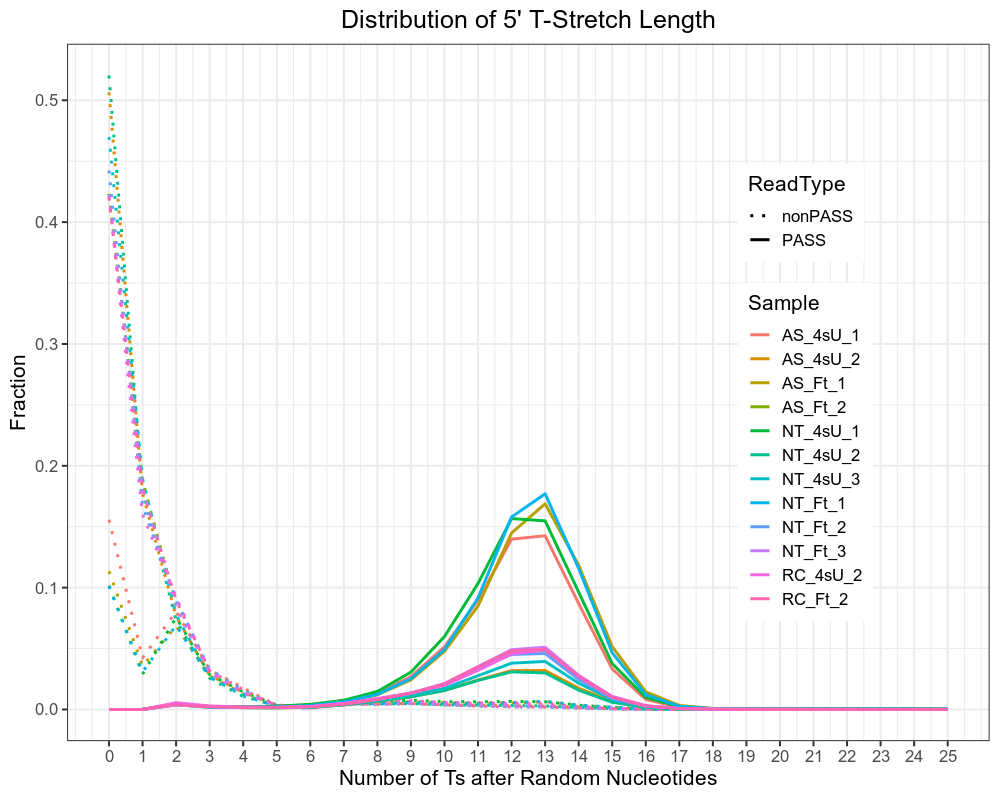

In [37]:
%%R -i result_dir_str,TS -w 1000 -h 800 -r 100

require(dplyr)
require(tidyr)
require(ggplot2)

# Calculation using dplyr and tidyr
TS = mutate(TS, T_Stretch_Length = as.numeric(rownames(TS))) %>% 
     gather(sample_name, Count, -T_Stretch_Length) %>%
     mutate(ReadType = sub("^.+\\.(.+)$", "\\1", sample_name)) %>%
     mutate(Sample = sub("(^.+)\\..+$", "\\1", sample_name)) %>%
     group_by(Sample) %>% 
     mutate(Fraction = Count/sum(Count))  

# Create plot 
p = ggplot(TS, aes(x = T_Stretch_Length, y = Fraction, color = Sample)) + 
    geom_line(aes(linetype = ReadType), size = 1) + 
    scale_linetype_manual(values = c(3,1)) +
    scale_x_continuous(breaks = 0:25) +
    xlab("Number of Ts after Random Nucleotides") +
    ggtitle("Distribution of 5' T-Stretch Length") +
    theme(legend.position=c(0.8, 0.5), plot.title = element_text(hjust = 0.5))

# Display in notebook
print(p)

# Save to pdf
pdf(file.path(result_dir_str, 'T_stretch_len.pdf'), 8, 6)
print(p)
dev.off()

## 12. Create UCSC genome browser tracks (Optional) 
This step uses the UCSC genome browser to visualize PASS and nonPASS reads. *An http-enabled server is required to serve the bigWig files.* 

In [38]:
pass_files = sorted([str(sam_file) for sam_file in sam_dir.glob('*.Aligned.out.pass')])
nonpass_files = sorted([str(sam_file) for sam_file in sam_dir.glob('*.Aligned.out.nonpass')])

In [39]:
# Make UCSC genome browser tracks for PASS reads
ps.make_url(project = PROJECT, 
            experiment = EXPERIMENT, 
            sam_dir= sam_dir, 
            sam_files = pass_files, 
            genome_size = str(genome_size), 
            sample_description = sample_description, 
            processes = WORKERS, 
            keep_bam = False, 
            bigDataUrl = f'http://{HTTP_SERVER}/{HTTP_USER}/bigwig/')

# Prepare for uploading files
pass_bw_dir = sam_dir/PROJECT/EXPERIMENT/'PASS'
pass_bw_dir.mkdir(parents=True, exist_ok=True)

os.system(f'mv {str(sam_dir)}/*.bw {str(pass_bw_dir)}')
os.system(f'mv {str(sam_dir)}/bigwigCaller.txt {str(pass_bw_dir)}')

0

In [40]:
# Upload the bigwig and track definition files to the http-enabled server
cmd = f'ssh {HTTP_USER}@{HTTP_SERVER} mkdir ~/../www/{HTTP_USER}/bigwig/{PROJECT}'
os.system(cmd)

cmd = (f'scp -r {str(sam_dir/PROJECT/EXPERIMENT)} '
       f'{HTTP_USER}@{HTTP_SERVER}:~/../www/{HTTP_USER}/bigwig/{PROJECT}')

if not os.system(cmd):
    print('bigWig files have been uploaded to http server.')
    os.system(f'rm -r {str(sam_dir/PROJECT)}')
    if SAVE_SPACE: os.system(f'rm -r {str(sam_dir)}')
    
    pass_url = (f'https://genome.ucsc.edu/cgi-bin/hgTracks?db={GENOME}'
                f'&position=chr17%3A35092728-35095537&hgct_customText='
                f'http://{HTTP_SERVER}/{HTTP_USER}/bigwig/{PROJECT}/'
                f'{EXPERIMENT}/PASS/bigwigCaller.txt'
                )    

    print('The following URL for PASS reads will be opened in a new tab automatically:')
    print(pass_url, '\n')
    
    sleep(5)
    import webbrowser
    _ = webbrowser.open(pass_url)
    
else:
    print('Cannot upload bigWig files to http server. Please make sure the server is available.')

bigWig files have been uploaded to http server.
The following URL for PASS reads will be opened in a new tab automatically:
https://genome.ucsc.edu/cgi-bin/hgTracks?db=mm9&position=chr17%3A35092728-35095537&hgct_customText=http://intron.njms.rutgers.edu/zhengdh/bigwig/stability/NT_AS_RC/PASS/bigwigCaller.txt 



As an example, we can take a look at the PASS and nonPASS reads mappted to the 3'UTRs of Nmt1 gene APA isoforms.
![Nmt1 3'UTR](../../../../images/Nmt1_3UTR.png)
We can see that in the PASS tracks, the reads are concentrated at two peaks, representing two pA sites. 

**This is the end for this notebook. The pA cluster files can be used for further analysis.**